## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## Data preprocessing

In [2]:
df = pd.read_csv("nvidia_stock_2015_to_2024.csv")
df = df.drop('Unnamed: 0', axis=1)
dates = df['date']
df['date']= pd.to_datetime(df['date'])
df

,date,open,high,low,close,adjclose,volume
0,2015-01-02,0.503250,0.507000,0.495250,0.503250,0.483218,113680000
1,2015-01-05,0.503250,0.504750,0.492500,0.494750,0.475056,197952000
2,2015-01-06,0.495500,0.496000,0.479250,0.479750,0.460654,197764000
3,2015-01-07,0.483250,0.487500,0.477000,0.478500,0.459453,321808000
4,2015-01-08,0.484000,0.499500,0.483750,0.496500,0.476737,283780000
...,...,...,...,...,...,...,...
2364,2024-05-24,104.448997,106.474998,103.000000,106.469002,106.460258,429494000
2365,2024-05-28,110.244003,114.939003,109.883003,113.901001,113.891647,652728000
2366,2024-05-29,113.050003,115.491997,110.901001,114.824997,114.815567,557442000
2367,2024-05-30,114.650002,115.819000,109.663002,110.500000,110.490921,487350000


## Create Training and Testing Data

In [3]:
data = df[['adjclose']]

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(data)

In [5]:
train_size = int(len(scaled_df) * 0.8 )
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

In [6]:
def create_seq(data, seq):
    x, y = [], []
    for i in range(len(data)- seq):
        x.append(data[i:i + seq])
        y.append(data[i + seq])
    return np.array(x), np.array(y)

seq = 60
x_train, y_train = create_seq(train_data,seq)
x_test, y_test = create_seq(test_data,seq)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] ,1))

## Import LSTM Model from tensorflow Library

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Creating LSTM Model

In [27]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopper = EarlyStopping(monitor='val_loss', patience =10, restore_best_weights=True)
history = model.fit(x_train, y_train , batch_size=16, epochs = 100, validation_data=(x_test, y_test), callbacks=[early_stopper])

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 8.1015e-04 - val_loss: 0.0033
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 1.3318e-04 - val_loss: 0.0029
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 1.5453e-04 - val_loss: 0.0081
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 1.3015e-04 - val_loss: 0.0029
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 1.2116e-04 - val_loss: 0.0035
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 1.0670e-04 - val_loss: 0.0053
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 1.0972e-04 - val_loss: 0.0036
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 9.5493e-05 - val_loss: 7.3991e-04
Epoch 9/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 1.1285e-04 - val_loss: 0.0041
Epoch 10/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 1.2954e-04 - val_loss: 0.0025
Epoch 11/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 9.8709e-05 - val_loss: 

In [28]:
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

valid = data[train_size + seq:]
assert len(valid) == len(pred)
valid['Predictions'] = pred

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


/var/folders/8q/45jlhv2x4_9784chr97d04_h0000gn/T/ipykernel_1904/1559746577.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = pred


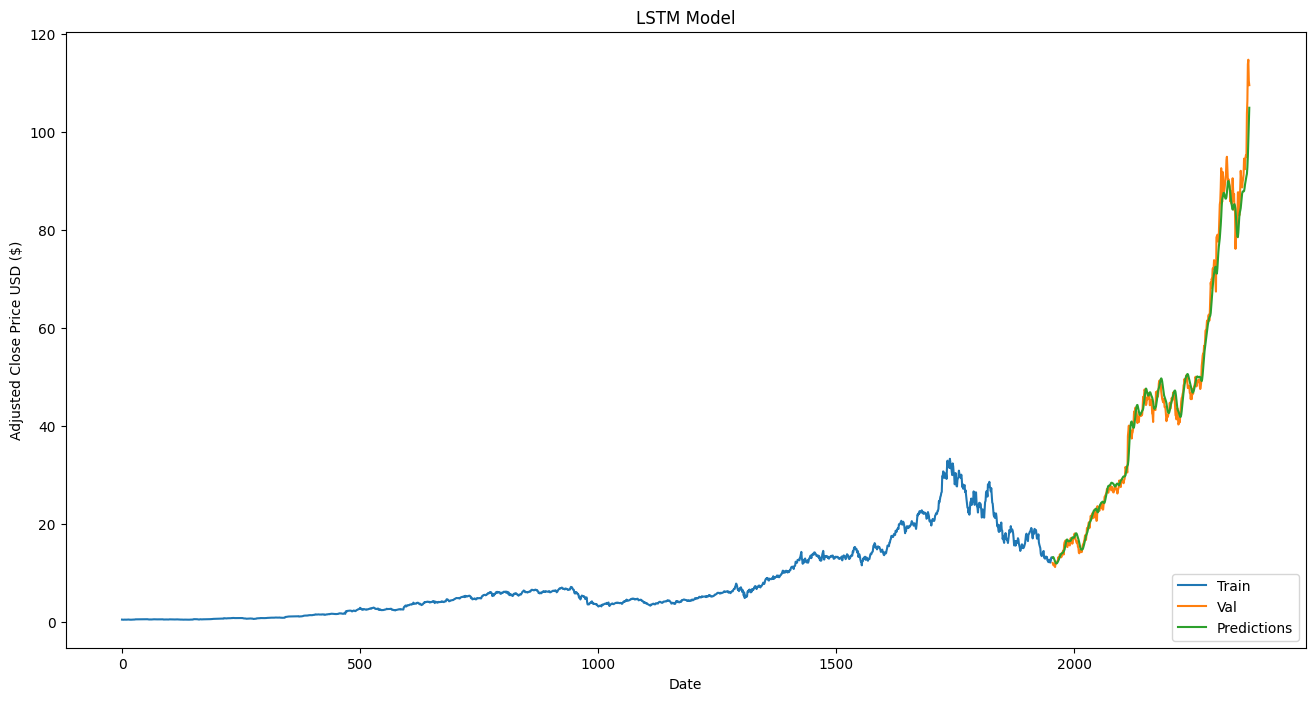

In [30]:
plt.figure(figsize=(16, 8))
plt.title('LSTM Model')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price USD ($)')
plt.plot(data[:train_size + seq]['adjclose'])
plt.plot(valid[['adjclose', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_scaled, pred))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 2.84169051923107


In [31]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,105 (1.75 MB)

 Trainable params: 152,701 (596.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 305,404 (1.17 MB)

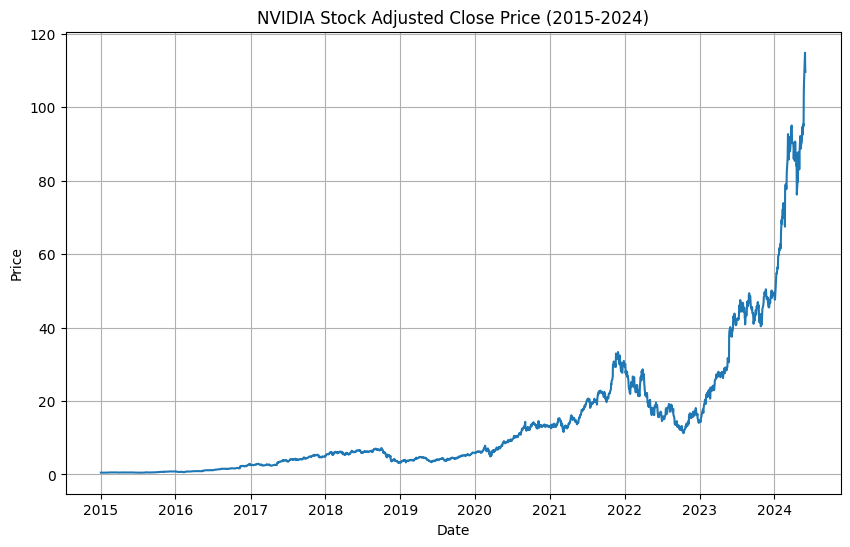

In [19]:
dfa = df[['adjclose', 'date']]

# Plot 'adjclose' against 'date'
plt.figure(figsize=(10, 6))
plt.plot(dfa['date'], dfa['adjclose'])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("NVIDIA Stock Adjusted Close Price (2015-2024)")
plt.grid(True)
plt.show()